In [1]:
import requests
import pandas as pd
import arrow
import datetime
import numpy as np

import warnings

import mplfinance as mpf
import matplotlib.pyplot as plt

In [2]:
company =[ "CIPLA","TCS","INFY","INFRATEL","ITC","HCLTECH","VEDL","WIPRO","BRITANNIA","UPL","RELIANCE","TECHM","M_M","SUNPHARMA","NESTLEIND",
"HINDUNILVR","DRREDDY","TATASTEEL","BHARTIARTL","NTPC","ONGC","TITAN","POWERGRID","HINDALCO","ASIANPAINT","TATAMOTORS","SHREECEM",
"GRASIM","IOC","HEROMOTOCO","BAJAJFINSV","ADANIPORTS","EICHERMOT","COALINDIA","JSWSTEEL","KOTAKBANK","LT","GAIL","HDFCBANK",
"SBIN","BAJAJ-AUTO","BAJFINANCE","BPCL","HDFC","MARUTI","ULTRACEMCO","AXISBANK","ICICIBANK","ZEEL","INDUSINDBK" ]

dates = ['2020-04-01','2020-04-03','2020-04-07','2020-04-08','2020-04-09','2020-04-13','2020-04-15','2020-04-16','2020-04-17','2020-04-20','2020-04-21','2020-04-22','2020-04-24','2020-04-27','2020-04-28','2020-04-29']
# 23-04 & 30-04 Missing data between 10.25 - 11.25

In [3]:
def style():
    mc = mpf.make_marketcolors(
                            up='tab:green',down='tab:red',
                            edge='black',
                            wick={'up':'green','down':'red'},
                            volume={'up':'green','down':'red'},
                           )

    return mpf.make_mpf_style(marketcolors=mc)

def bollvwap(ndata):
    return [mpf.make_addplot(ndata.MBB,color='black'),mpf.make_addplot(ndata.UBB,color='black'),mpf.make_addplot(ndata.LBB,color='black'),mpf.make_addplot(ndata.VWAP, color='blue')]

def boll(ndata):
    return [mpf.make_addplot(ndata.MBB,color='black'),mpf.make_addplot(ndata.UBB,color='black'),mpf.make_addplot(ndata.LBB,color='black')]

def plotatr(ndata):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.plot(ndata.ATR)
    plt.ylabel('ATR')
    
def plotrsi(ndata):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.plot(ndata.RSI)
    plt.ylabel('RSI')
    
def dayplot(rdata):
    ndata  = rdata.copy()
    ndata.rename(columns={'Datetime':'Date'}, inplace=True)
    ndata.set_index('Date', inplace=True)
    ndata.index = pd.to_datetime(ndata.index)
    mpf.plot(ndata,addplot=boll(ndata),type='candle',volume=True,style=style(),figratio=(20,20))
    #plotrsi(ndata)
    #plotatr(ndata)

In [4]:
def daydata(ndata, ndate):
    i = 0
    while(True):
        if(ndata['Datetime'][ndata.index == i].values[0][0:10] == ndate):
            break
        else:
            i += 1
    st = i
    
    if(ndate == ndata.tail(1).Datetime.values[0][0:10]):
        en = len(ndata)
    else:
        while(True):
            if(ndata['Datetime'][ndata.index == i].values[0][0:10] != ndate):
                break
            else:
                i += 1
                en = i
        
    return ndata[st:en]

In [5]:
def simulate(data, date, name, RSIrange, RSIlimit, simperiod, takeprofit, stoploss, good, bad, mediocre):
    scanstart = '11:00:00'
    scanend ='14:00:00'
    day = daydata(data, date)
    
    if(day[day['Datetime']==date+' '+scanstart].empty or day[day['Datetime']==date+' '+scanend].empty):
        print(date+": Data missing")
        return
    
    startind = day[day['Datetime']==date+' '+scanstart].index.tolist()[0]
    endind = day[day['Datetime']==date+' '+scanend].index.tolist()[0]
    ind = startind
    a=0

    while(True):
        if(ind == None):
            print("Start time not found in day's data")
            break
        
        temp = day[day.index == ind]
    
        if((temp.index == endind)[0]):
            break
        
        limit= 0.75*temp['MBB'] + 0.25*temp['LBB']
    
        conditionpricerange = (temp['Open']<limit).tolist()[0] & (temp['Close']<limit).tolist()[0] & (temp['Open']<temp['Close']).tolist()[0]
        conditionRSIrange = (day.loc[startind:ind].RSI.max() - day.loc[startind:ind].RSI.min()) > RSIrange
        conditionRSIlong1 = day.loc[ind].RSI<RSIlimit
        conditionRSIlong2 = day.loc[ind-1].RSI < day.loc[ind].RSI
    
        if(conditionpricerange and conditionRSIlong1 and conditionRSIlong2 and a<1 and conditionRSIrange):
            print(temp['Datetime'].values[0]+": "+name+" Long Signal")
            
            res = track(day, temp.index[0], takeprofit, stoploss, simperiod)
            
            print("Plotting Graph for confirmation...")
            dayplot(day)
            
            if(res == 'Win'):
                good+=1
            elif(res=='Loss'):
                bad+=1
            elif(res=='Draw'):
                mediocre+=1
                
            a += 1
        
        ind+= 1

    #warnings.filterwarnings("ignore")
    return good, bad, mediocre;

In [6]:
def track(day, pos, winm, lossm, dur):
    per = day.loc[pos+1:pos+1+dur]
    wi = day.loc[pos].Close*(1+winm/100)
    lo = day.loc[pos].Close*(1-lossm/100)
    print('Entry Price: ' + str(day.loc[pos].Close) +' at '+day.loc[pos].Datetime)
    print('Target Price: ' + str(wi))
    print('Stoploss Price: ' + str(lo))
    print('Result:')
    if(per.index[per.Low<=lo].empty and per.index[per.High>=wi].empty):
        print('Draw at ' + day.loc[pos+1+dur].Datetime +' at '+ str(day.loc[pos+1+dur].Close))
        return 'Draw'
    elif(per.index[per.Low<=lo].empty and not per.index[per.High>=wi].empty):
        print('Win at ' + day.loc[per.index[per.High>=wi][0]].Datetime +' at '+ str(wi))
        return 'Win'
    elif(not per.index[per.Low<=lo].empty and per.index[per.High>=wi].empty):
        print('Loss at ' + day.loc[per.index[per.Low<=lo][0]].Datetime +' at '+ str(lo))
        return 'Loss'
    elif(per.index[per.Low<=lo][0] > per.index[per.High>=wi][0]):
        print('Win at ' + day.loc[per.index[per.High>=wi][0]].Datetime +' at '+ str(wi))
        return 'Win'
    else:
        print('Loss at ' + day.loc[per.index[per.Low<=lo][0]].Datetime +' at '+ str(lo))
        return 'Loss'

2020-04-01 13:15:00: TCS Long Signal
Entry Price: 1745.949951171875 at 2020-04-01 13:15:00
Target Price: 1759.0445758056642
Stoploss Price: 1740.7121013183594
Result:
Loss at 2020-04-01 13:20:00 at 1740.7121013183594
Plotting Graph for confirmation...


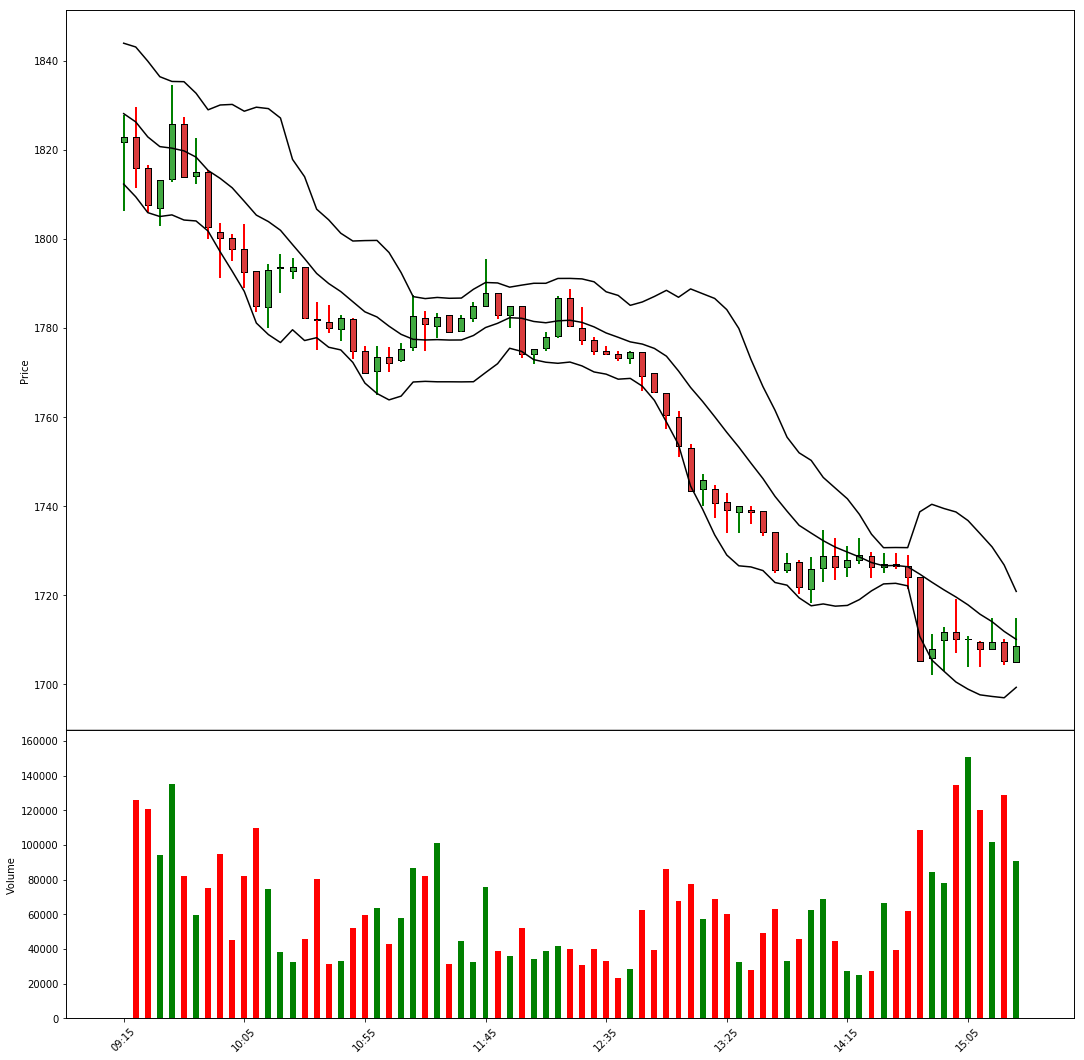

2020-04-03 12:50:00: INFY Long Signal
Entry Price: 586.5999755859375 at 2020-04-03 12:50:00
Target Price: 590.9994754028321
Stoploss Price: 584.8401756591796
Result:
Win at 2020-04-03 13:10:00 at 590.9994754028321
Plotting Graph for confirmation...


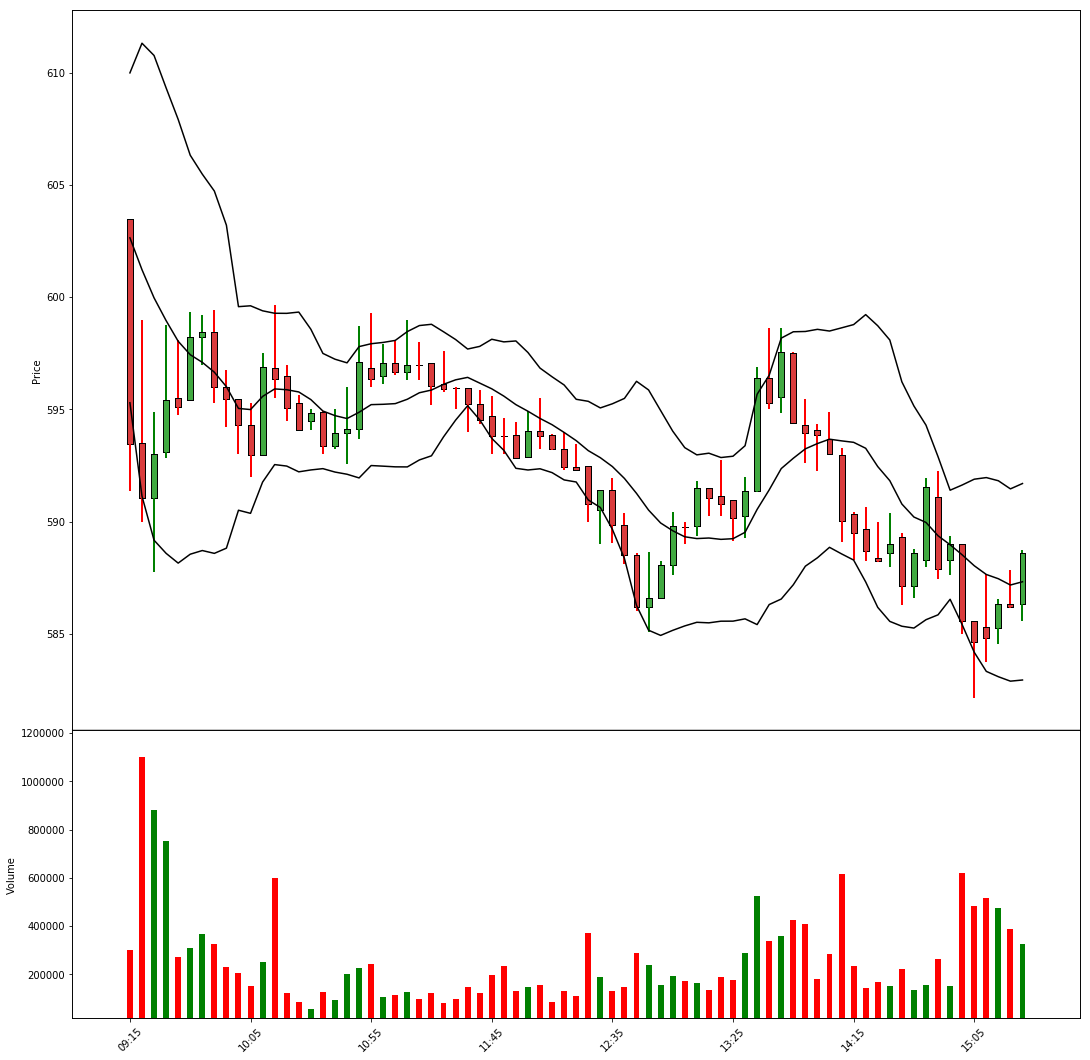

2020-04-17 12:05:00: ITC Long Signal
Entry Price: 187.3500061035156 at 2020-04-17 12:05:00
Target Price: 188.75513114929197
Stoploss Price: 186.78795608520505
Result:
Win at 2020-04-17 12:55:00 at 188.75513114929197
Plotting Graph for confirmation...


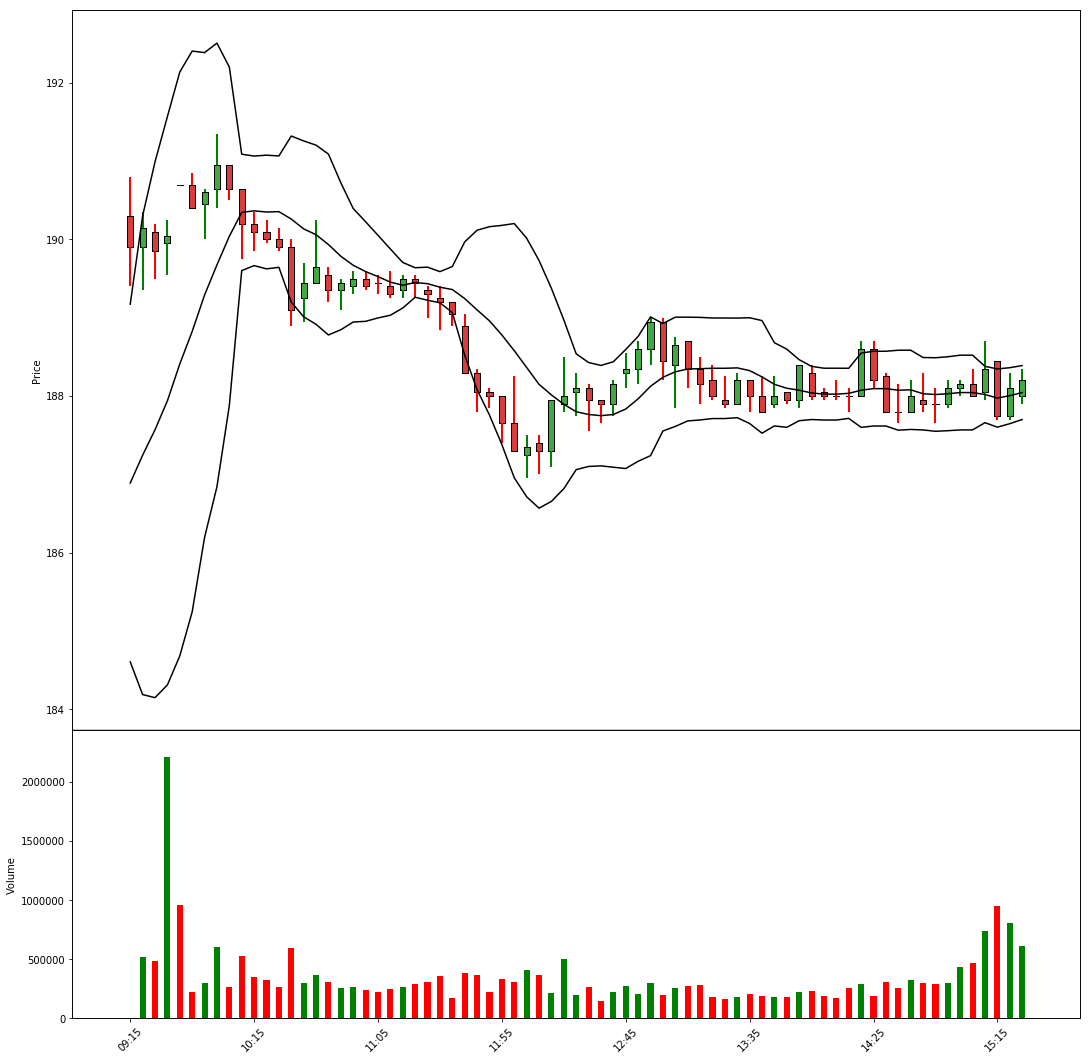

2020-04-16 13:55:00: HCLTECH Long Signal
Entry Price: 459.95001220703125 at 2020-04-16 13:55:00
Target Price: 463.399637298584
Stoploss Price: 458.57016217041013
Result:
Win at 2020-04-16 14:30:00 at 463.399637298584
Plotting Graph for confirmation...


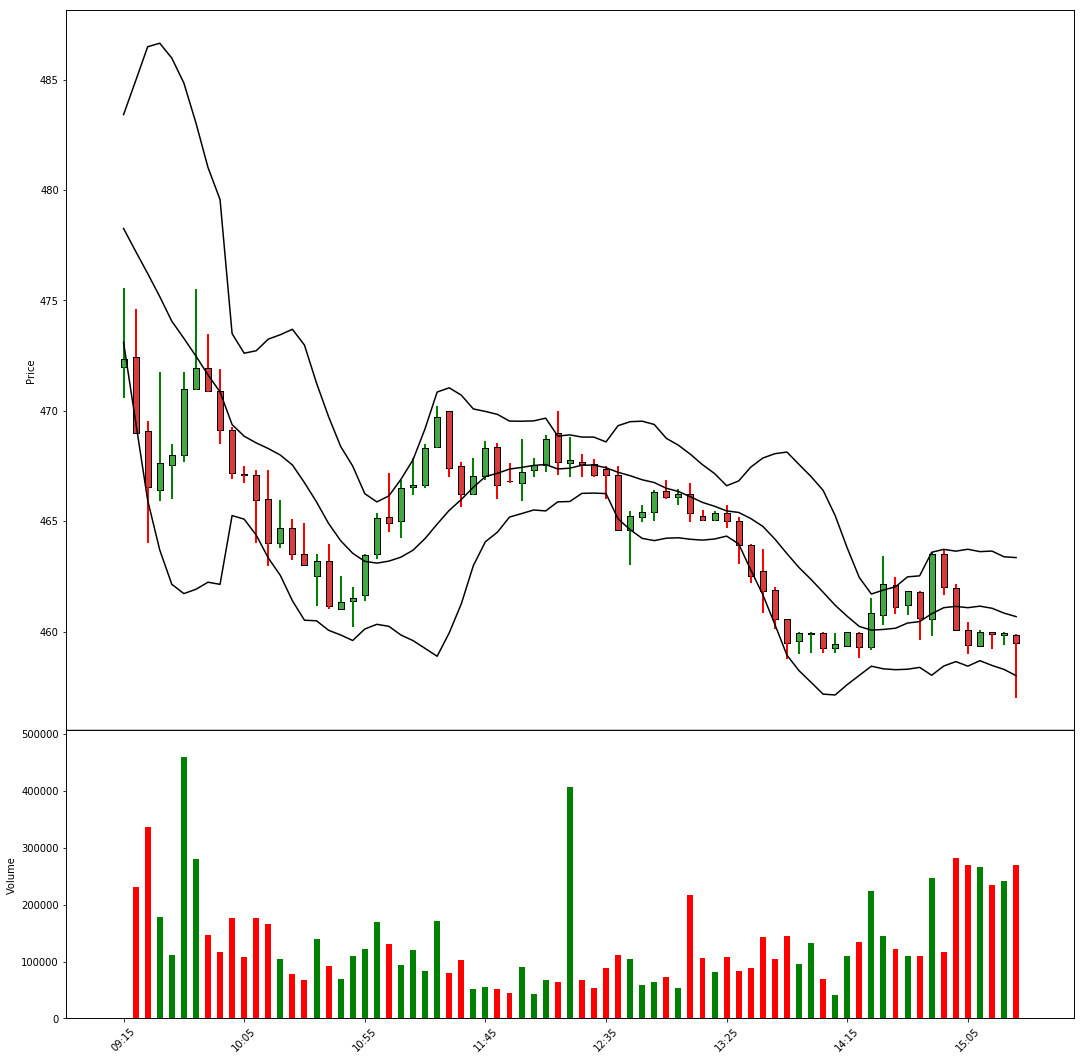

2020-04-15 13:50:00: RELIANCE Long Signal
Entry Price: 1185.199951171875 at 2020-04-15 13:50:00
Target Price: 1194.0889508056641
Stoploss Price: 1181.6443513183594
Result:
Loss at 2020-04-15 14:00:00 at 1181.6443513183594
Plotting Graph for confirmation...


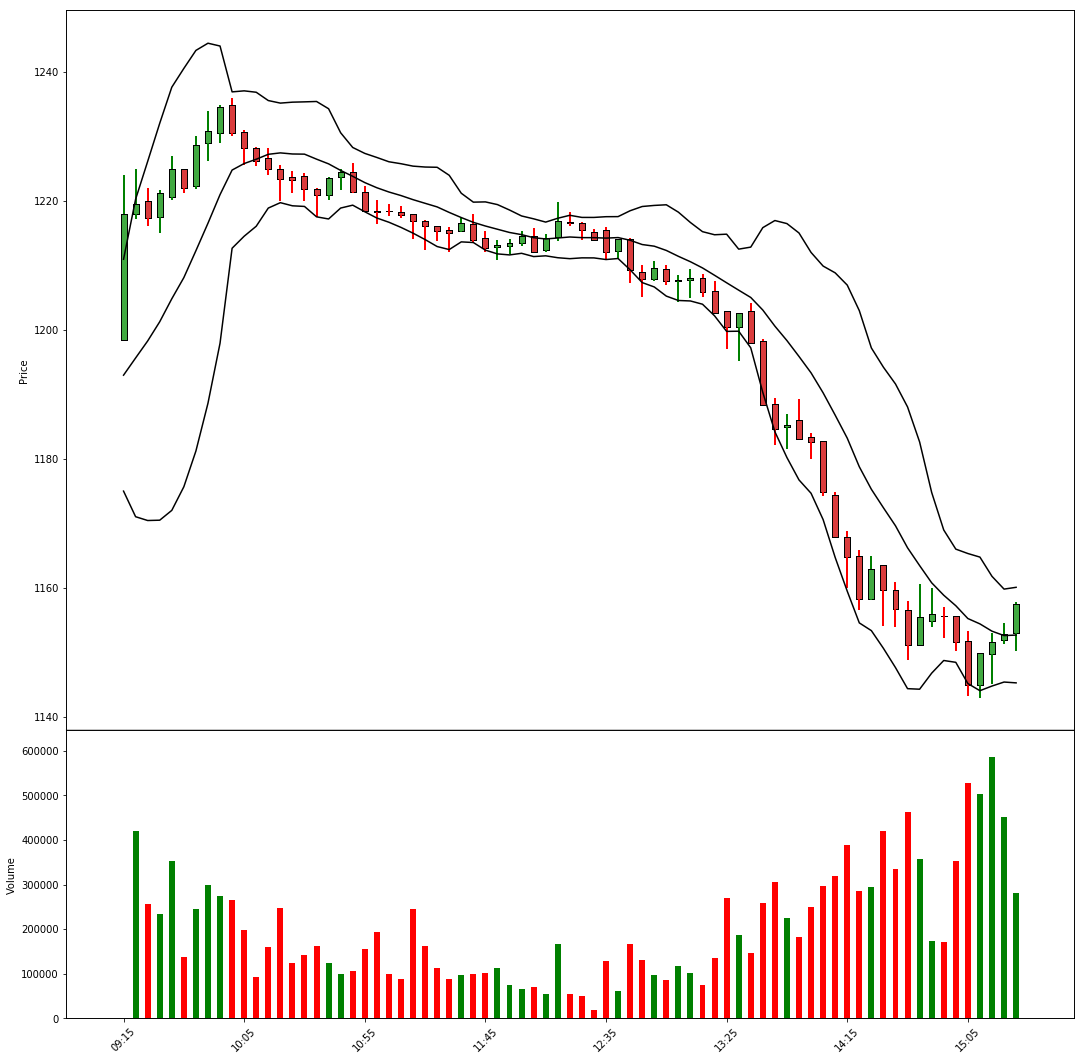

2020-04-21 12:30:00: RELIANCE Long Signal
Entry Price: 1177.25 at 2020-04-21 12:30:00
Target Price: 1186.079375
Stoploss Price: 1173.71825
Result:
Loss at 2020-04-21 12:45:00 at 1173.71825
Plotting Graph for confirmation...


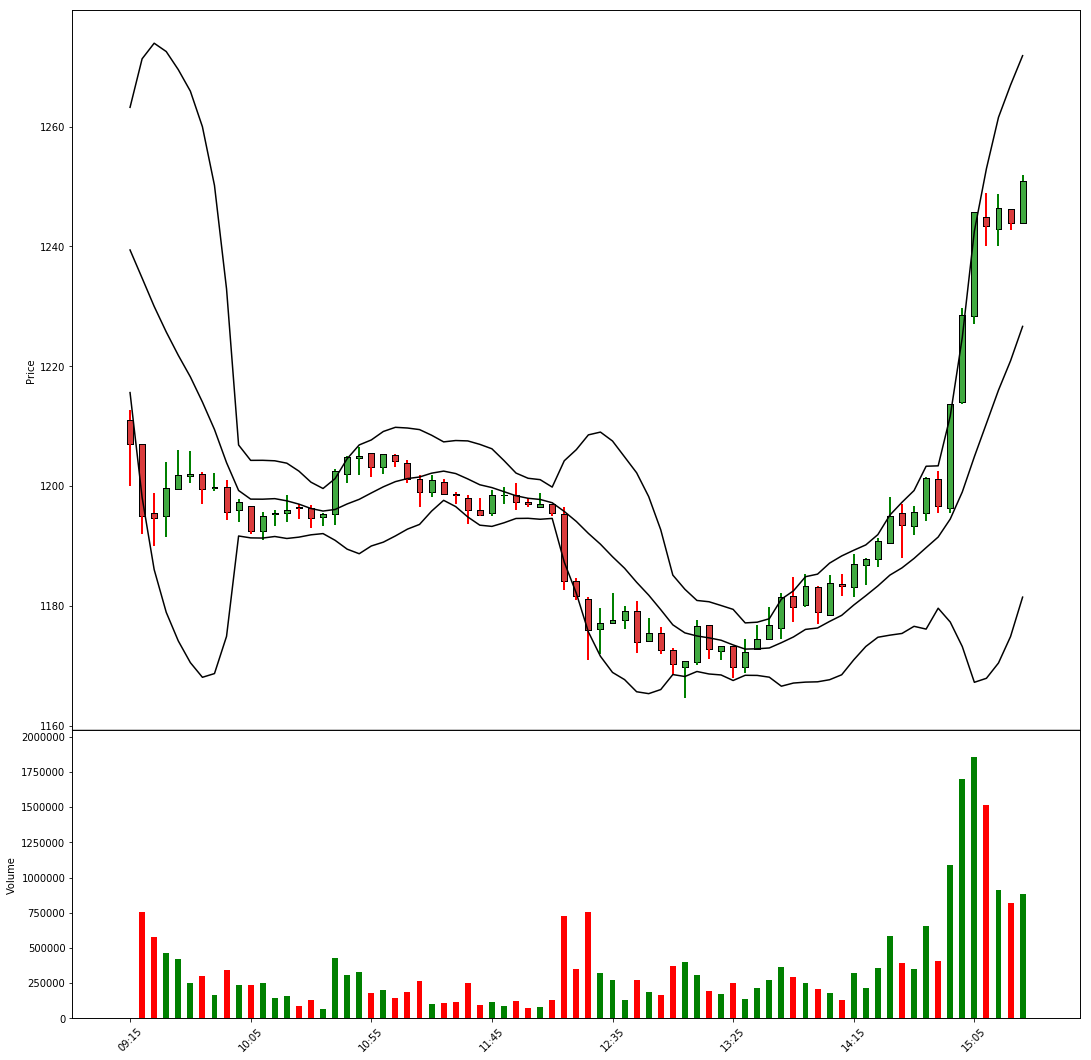

2020-04-29 13:50:00: NESTLEIND Long Signal
Entry Price: 17468.849609375 at 2020-04-29 13:50:00
Target Price: 17599.865981445313
Stoploss Price: 17416.443060546873
Result:
Win at 2020-04-29 14:30:00 at 17599.865981445313
Plotting Graph for confirmation...


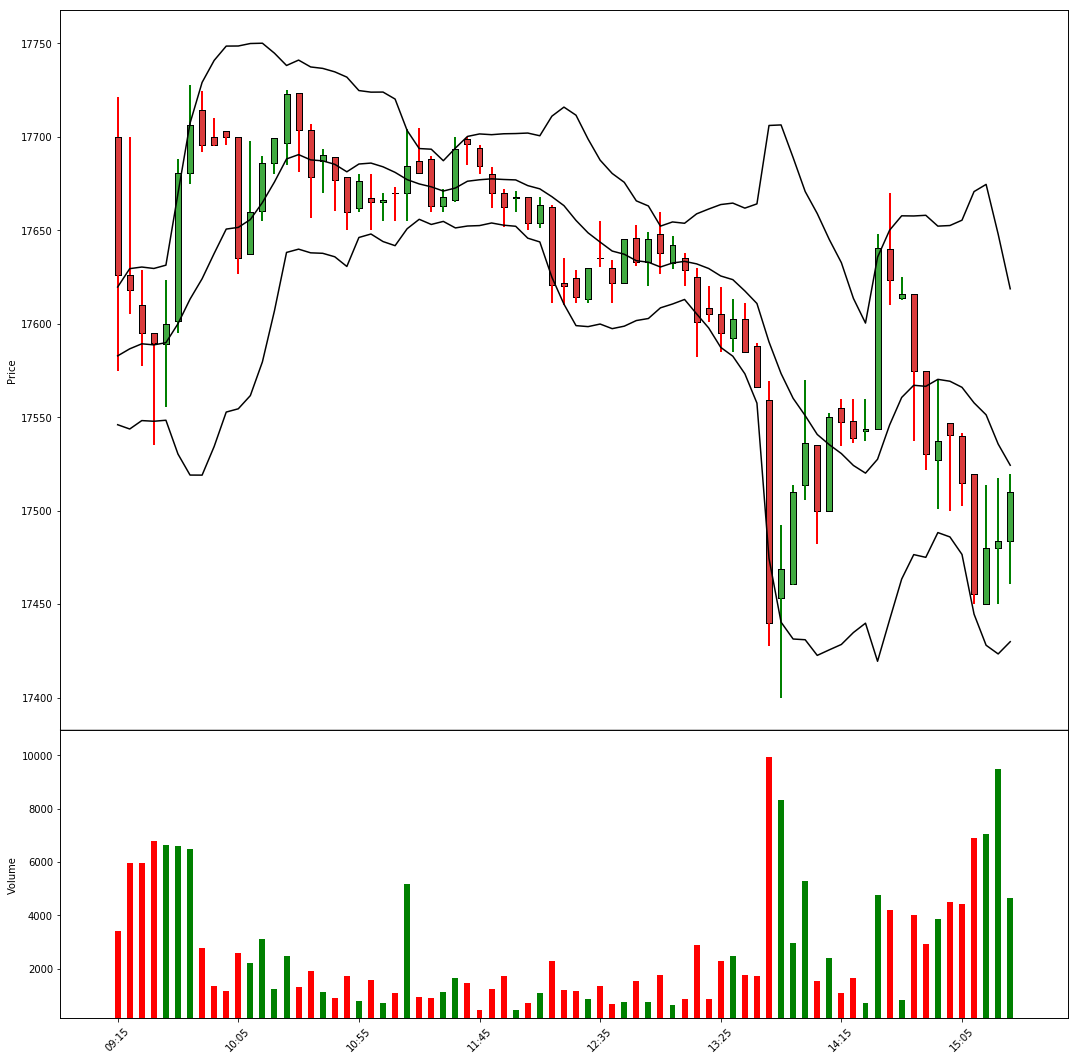

2020-04-08 13:25:00: HINDUNILVR Long Signal
Entry Price: 2454.449951171875 at 2020-04-08 13:25:00
Target Price: 2472.858325805664
Stoploss Price: 2447.0866013183595
Result:
Win at 2020-04-08 13:35:00 at 2472.858325805664
Plotting Graph for confirmation...


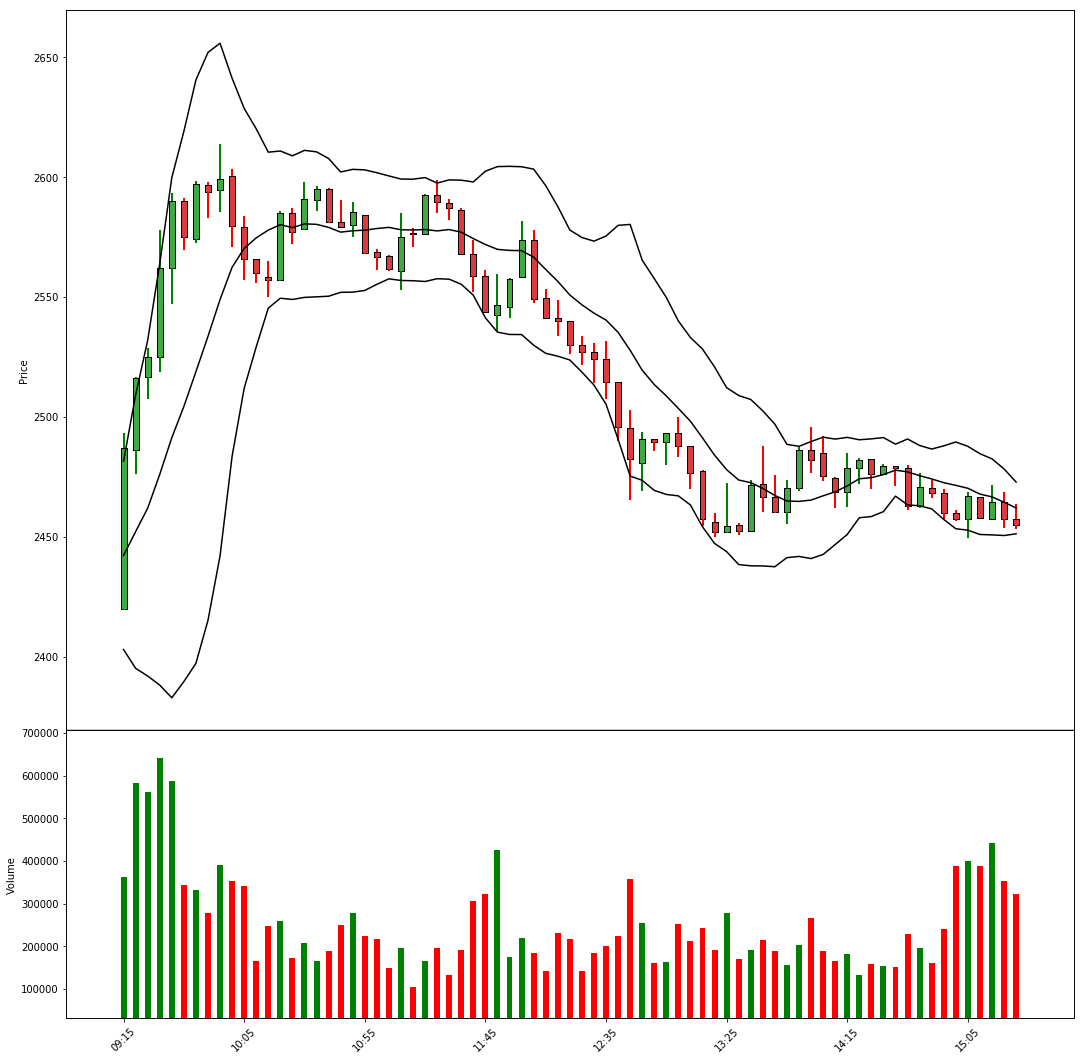

2020-04-01 13:35:00: POWERGRID Long Signal
Entry Price: 154.3000030517578 at 2020-04-01 13:35:00
Target Price: 155.45725307464602
Stoploss Price: 153.83710304260254
Result:
Win at 2020-04-01 14:20:00 at 155.45725307464602
Plotting Graph for confirmation...


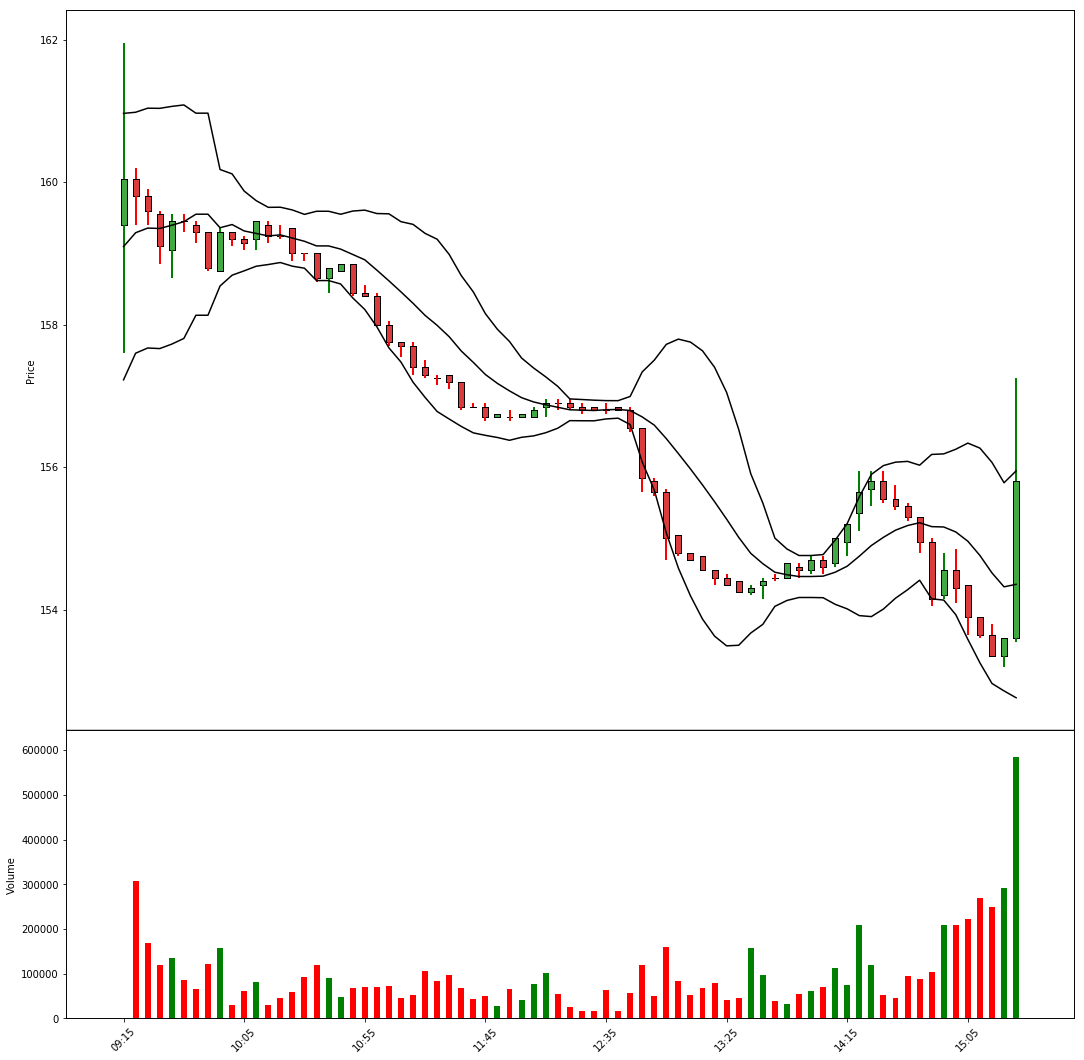

2020-04-13 13:25:00: POWERGRID Long Signal
Entry Price: 159.1999969482422 at 2020-04-13 13:25:00
Target Price: 160.393996925354
Stoploss Price: 158.72239695739745
Result:
Loss at 2020-04-13 13:30:00 at 158.72239695739745
Plotting Graph for confirmation...


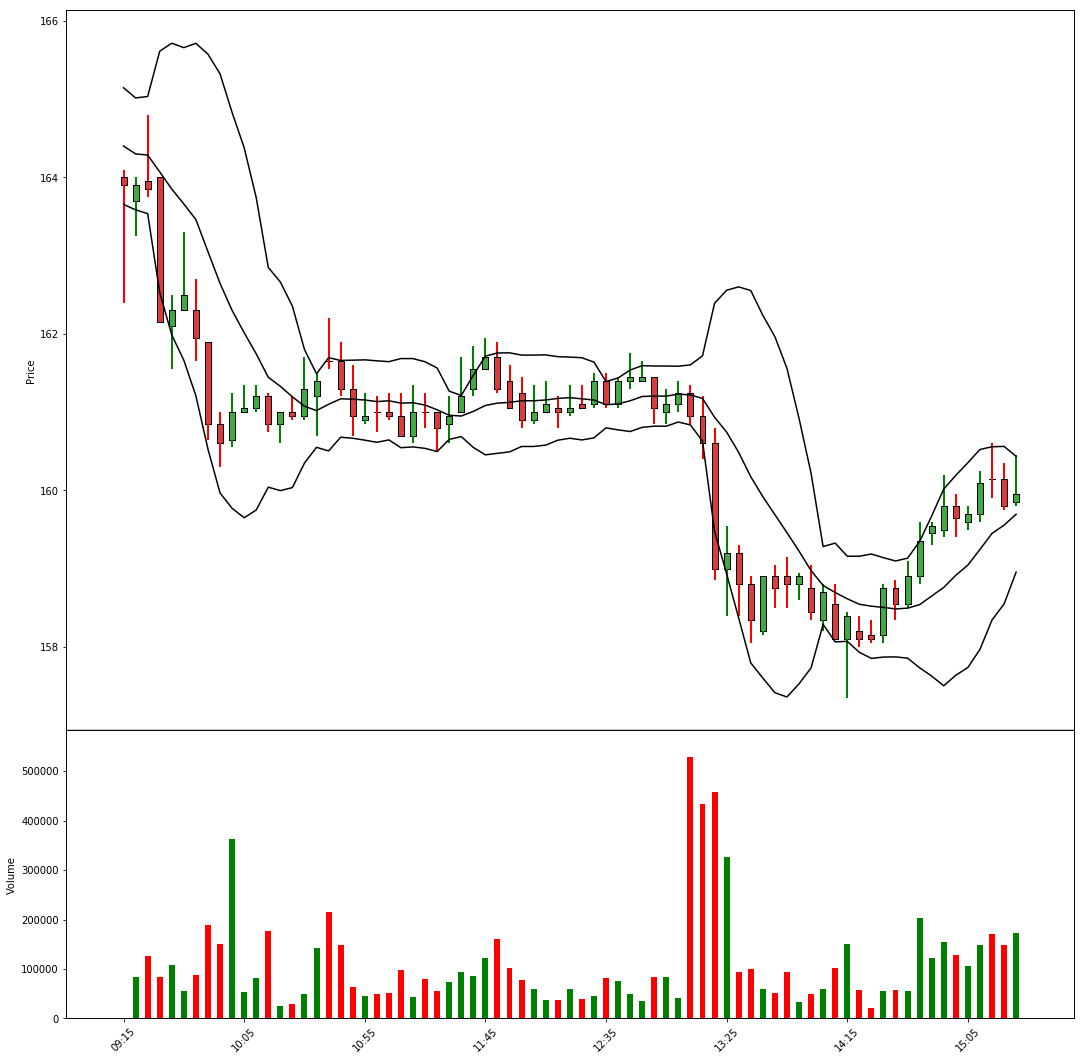

2020-04-29 12:50:00: POWERGRID Long Signal
Entry Price: 157.85000610351562 at 2020-04-29 12:50:00
Target Price: 159.033881149292
Stoploss Price: 157.37645608520506
Result:
Loss at 2020-04-29 13:35:00 at 157.37645608520506
Plotting Graph for confirmation...


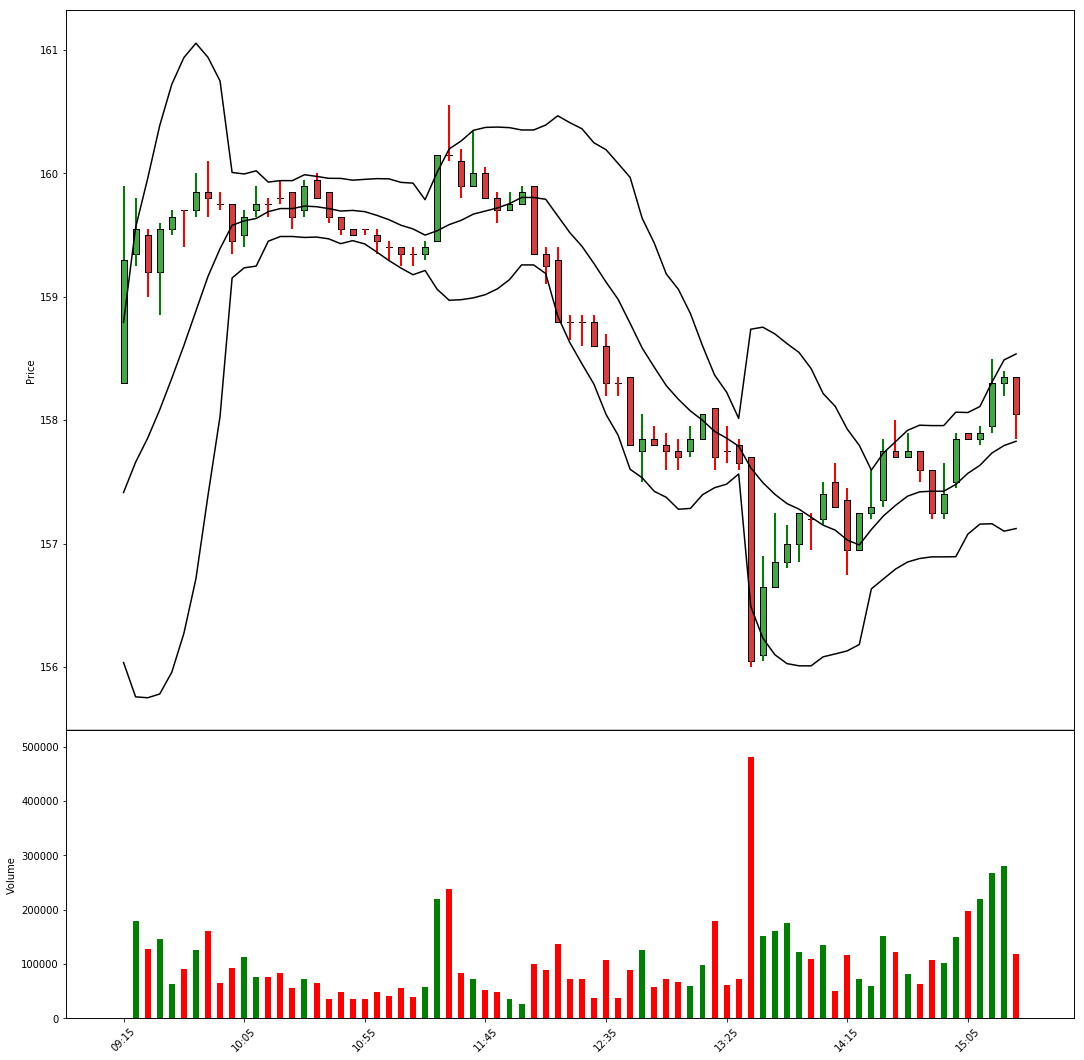

2020-04-29 13:55:00: HEROMOTOCO Long Signal
Entry Price: 1975.0 at 2020-04-29 13:55:00
Target Price: 1989.8125000000002
Stoploss Price: 1969.075
Result:
Loss at 2020-04-29 14:00:00 at 1969.075
Plotting Graph for confirmation...


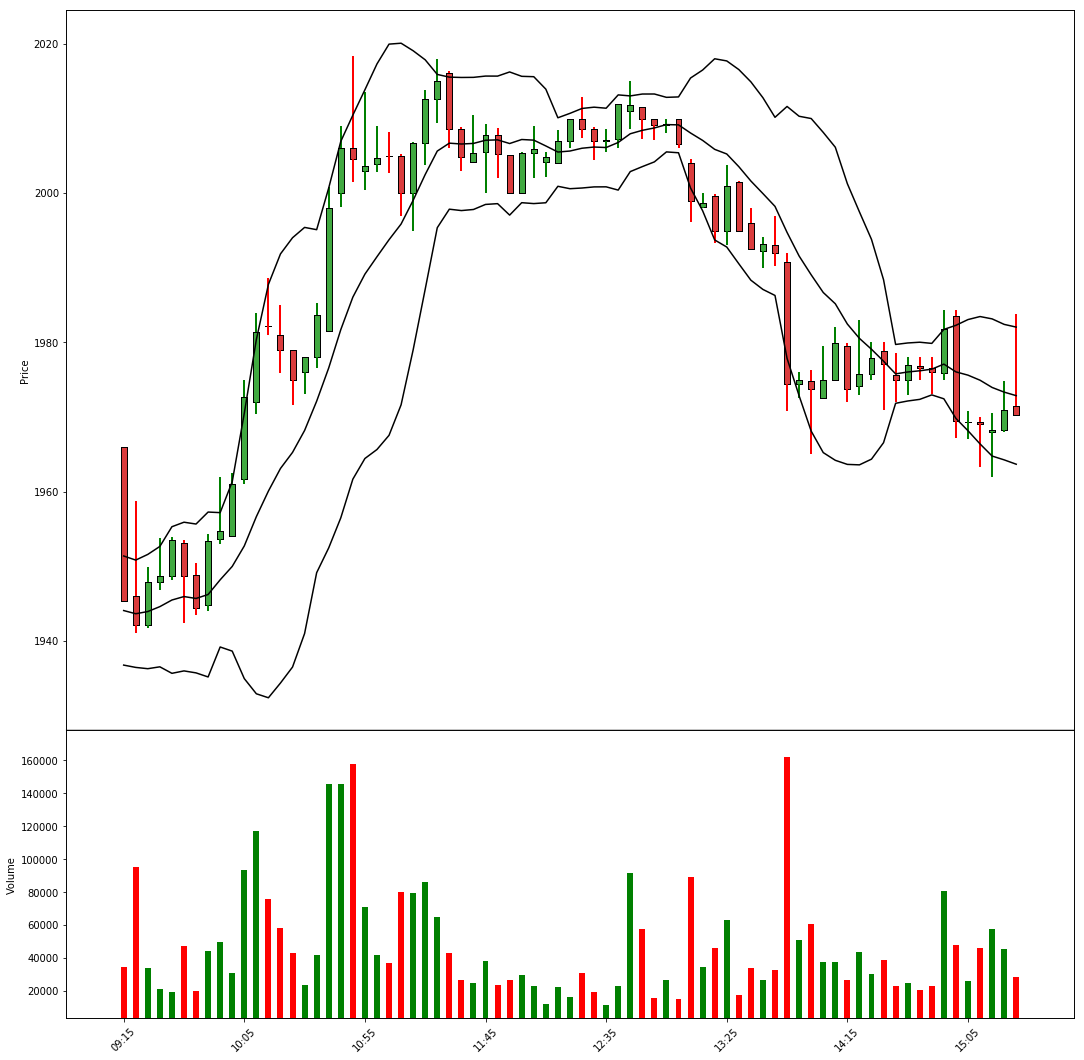

2020-04-13 13:15:00: BAJAJFINSV Long Signal
Entry Price: 4551.9501953125 at 2020-04-13 13:15:00
Target Price: 4586.089821777344
Stoploss Price: 4538.2943447265625
Result:
Loss at 2020-04-13 13:30:00 at 4538.2943447265625
Plotting Graph for confirmation...


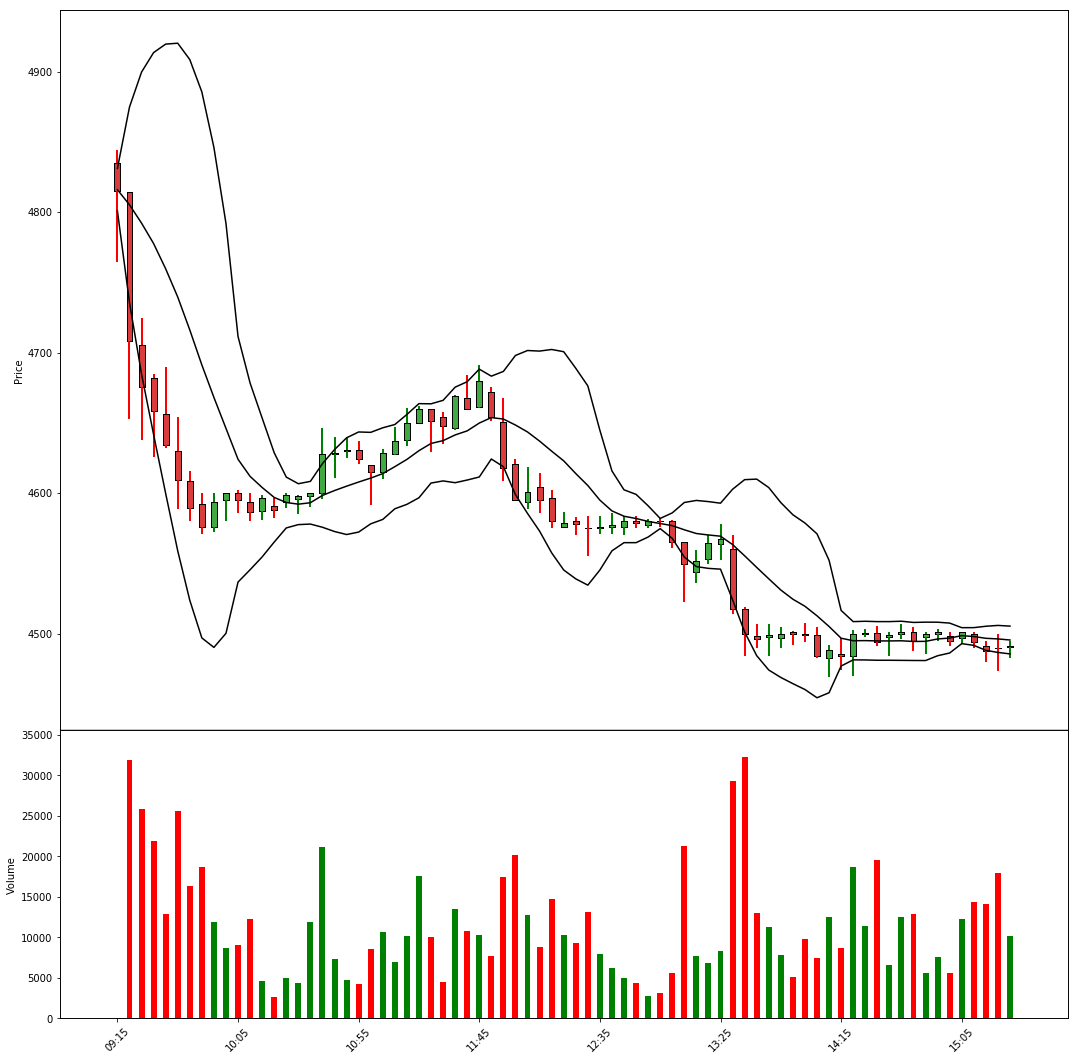

2020-04-15 13:50:00: EICHERMOT Long Signal
Entry Price: 13435.150390625 at 2020-04-15 13:50:00
Target Price: 13535.914018554688
Stoploss Price: 13394.844939453125
Result:
Loss at 2020-04-15 13:55:00 at 13394.844939453125
Plotting Graph for confirmation...


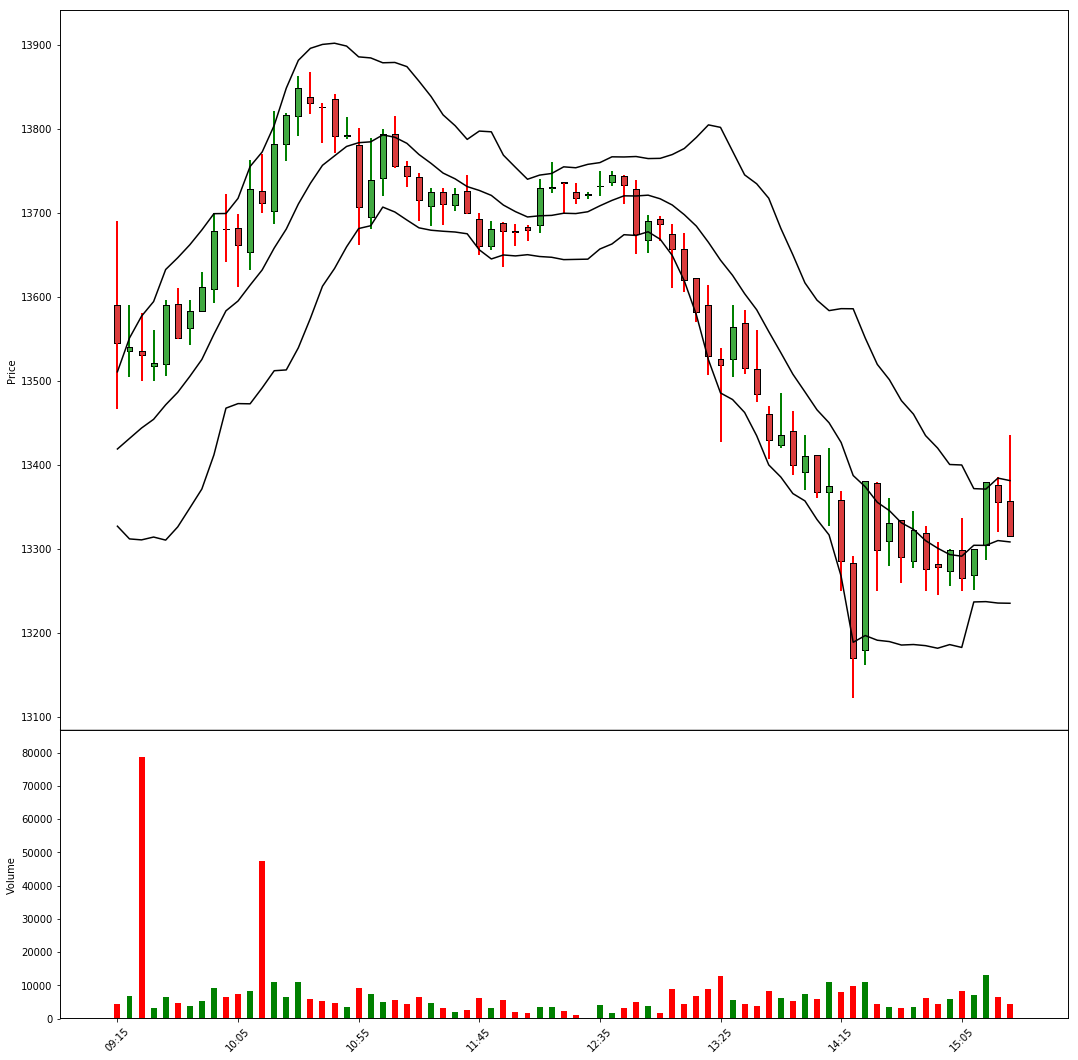

2020-04-28 13:10:00: COALINDIA Long Signal
Entry Price: 136.55000305175778 at 2020-04-28 13:10:00
Target Price: 137.57412807464598
Stoploss Price: 136.1403530426025
Result:
Loss at 2020-04-28 14:00:00 at 136.1403530426025
Plotting Graph for confirmation...


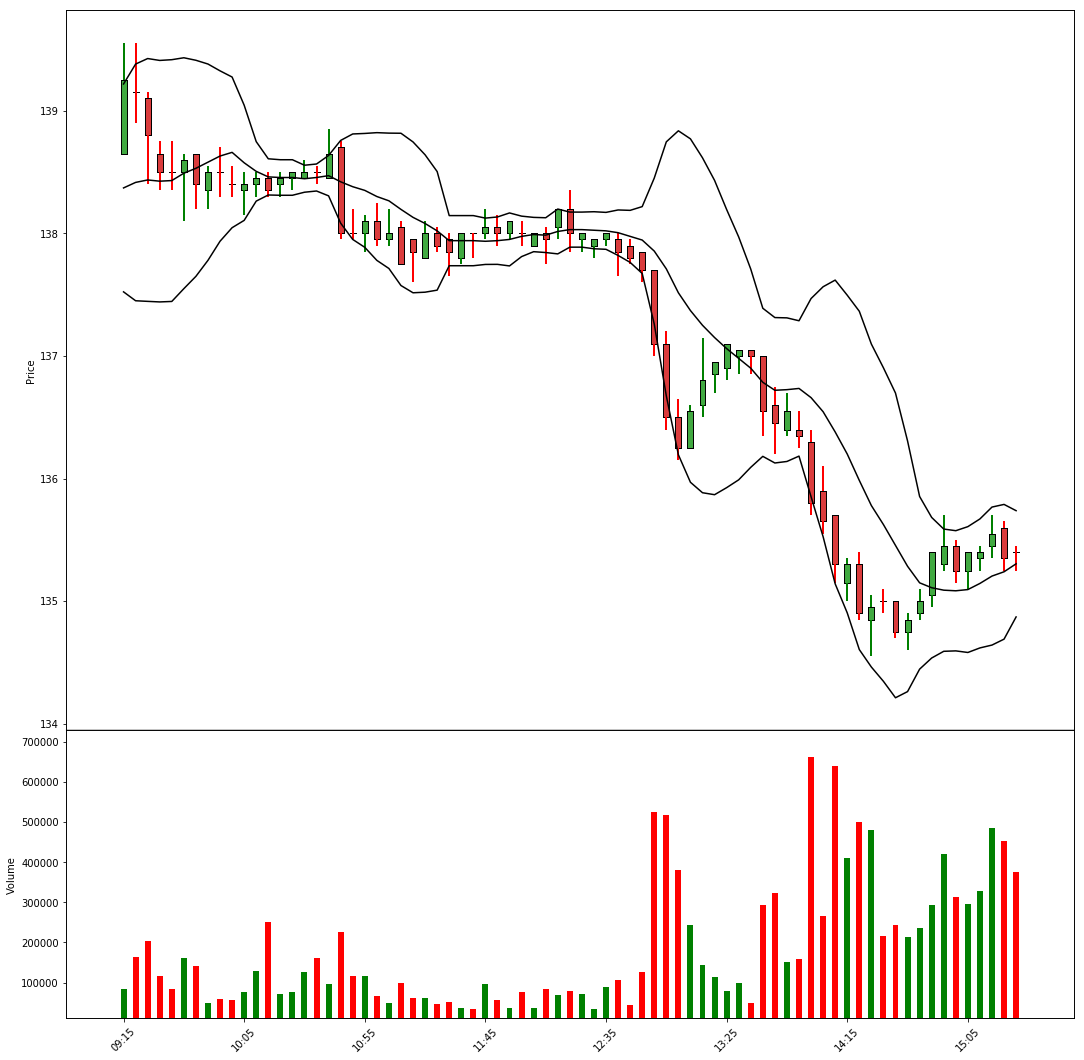

2020-04-15 13:25:00: KOTAKBANK Long Signal
Entry Price: 1211.5999755859375 at 2020-04-15 13:25:00
Target Price: 1220.686975402832
Stoploss Price: 1207.9651756591797
Result:
Win at 2020-04-15 13:30:00 at 1220.686975402832
Plotting Graph for confirmation...


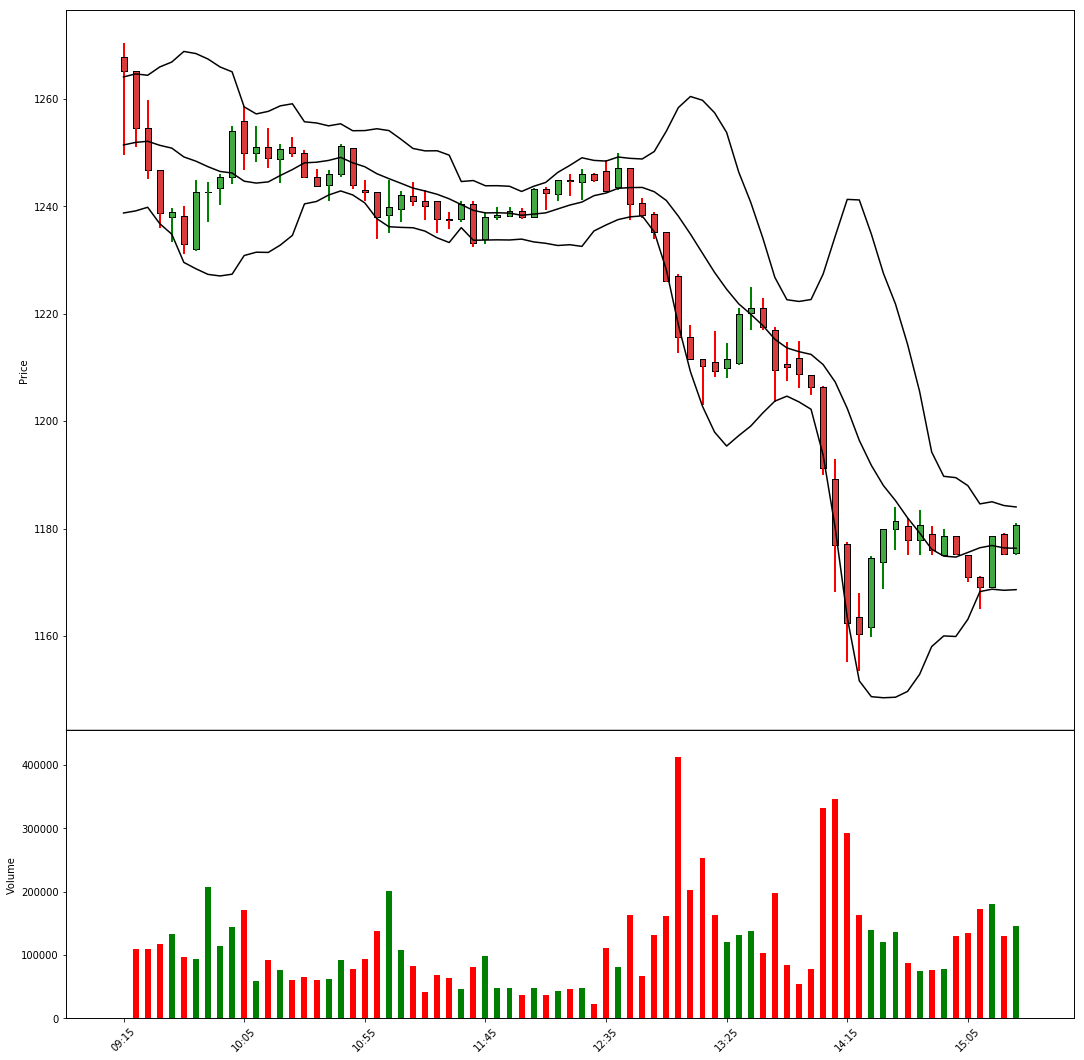

2020-04-21 13:00:00: KOTAKBANK Long Signal
Entry Price: 1129.0 at 2020-04-21 13:00:00
Target Price: 1137.4675
Stoploss Price: 1125.613
Result:
Win at 2020-04-21 13:10:00 at 1137.4675
Plotting Graph for confirmation...


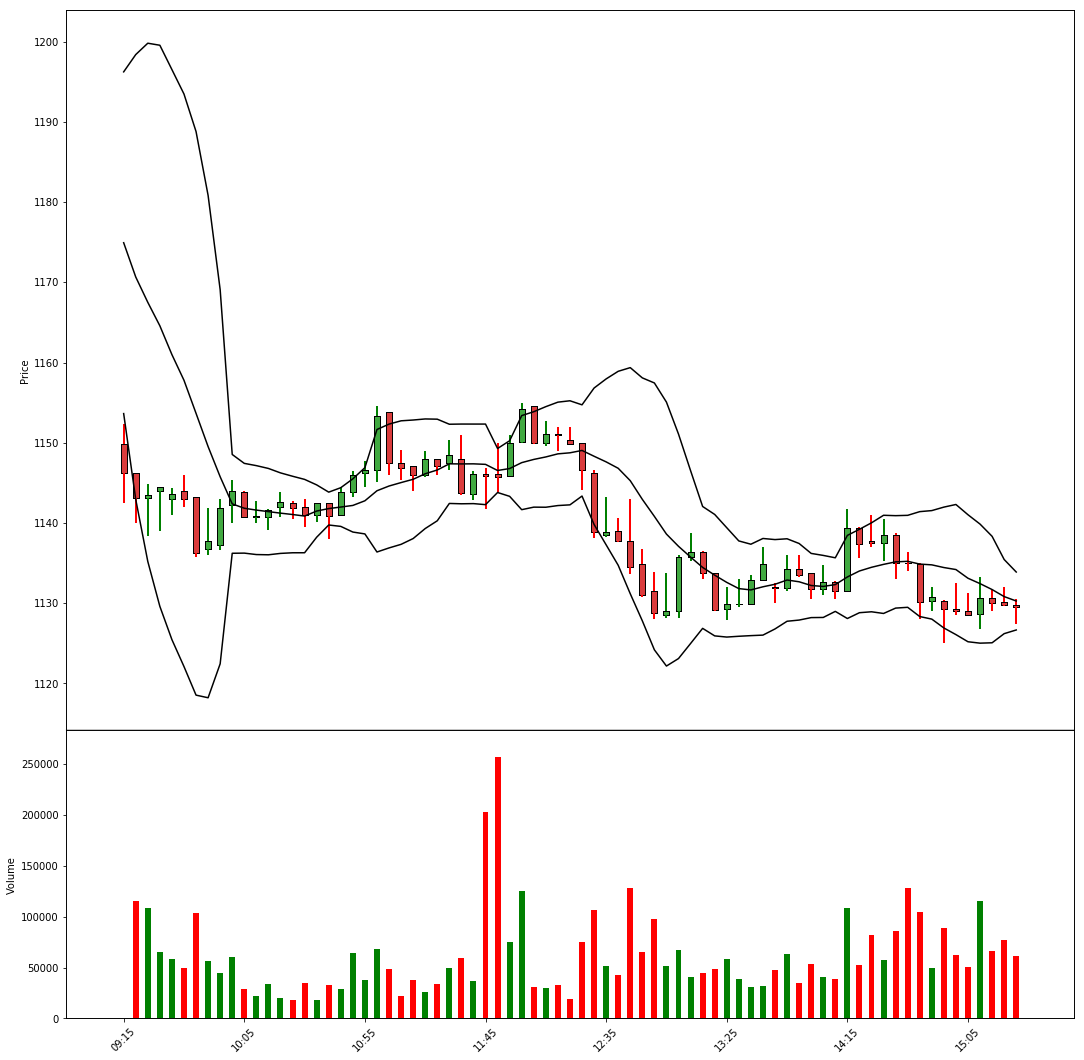

2020-04-21 12:50:00: HDFCBANK Long Signal
Entry Price: 916.0 at 2020-04-21 12:50:00
Target Price: 922.87
Stoploss Price: 913.252
Result:
Loss at 2020-04-21 12:55:00 at 913.252
Plotting Graph for confirmation...


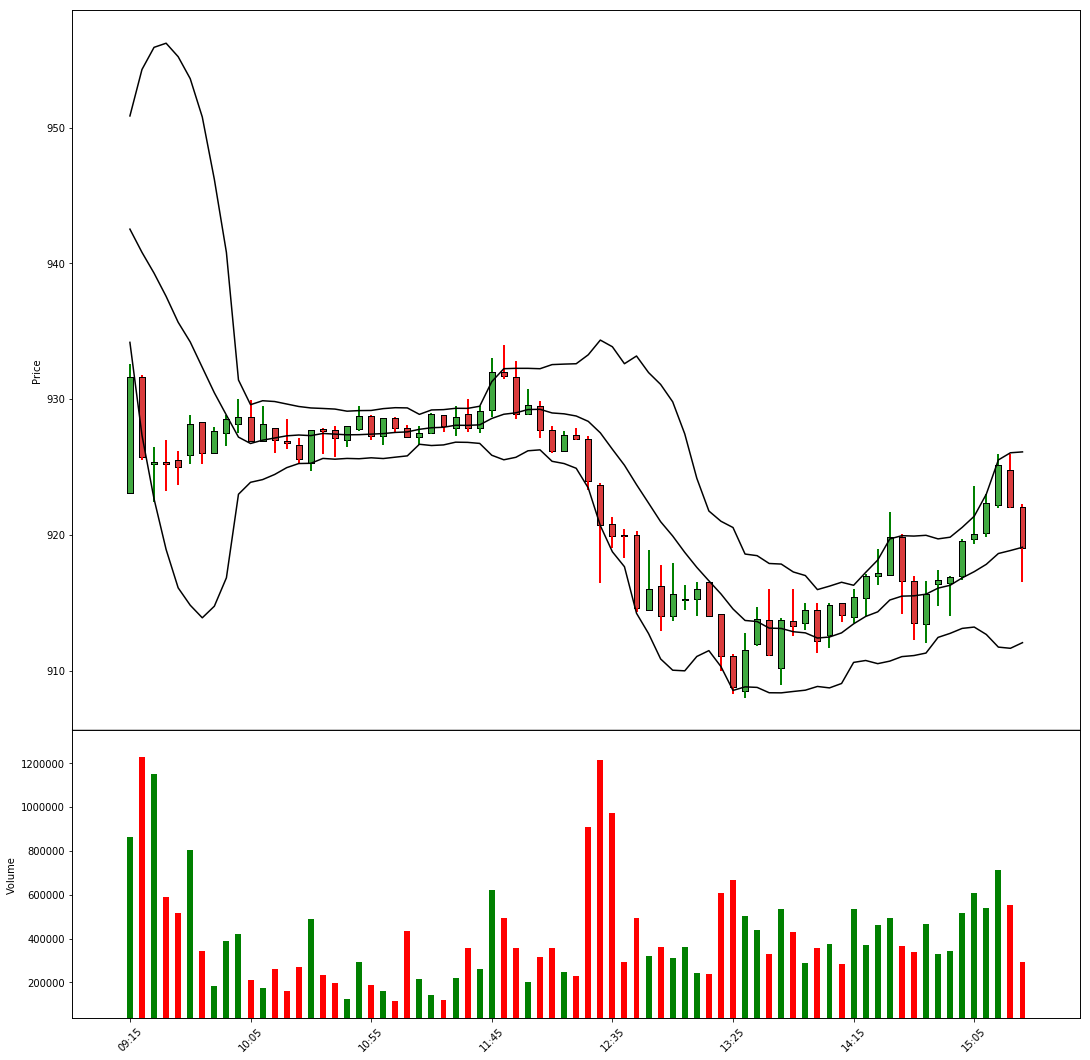

2020-04-21 12:40:00: SBIN Long Signal
Entry Price: 183.6999969482422 at 2020-04-21 12:40:00
Target Price: 185.077746925354
Stoploss Price: 183.14889695739745
Result:
Loss at 2020-04-21 13:05:00 at 183.14889695739745
Plotting Graph for confirmation...


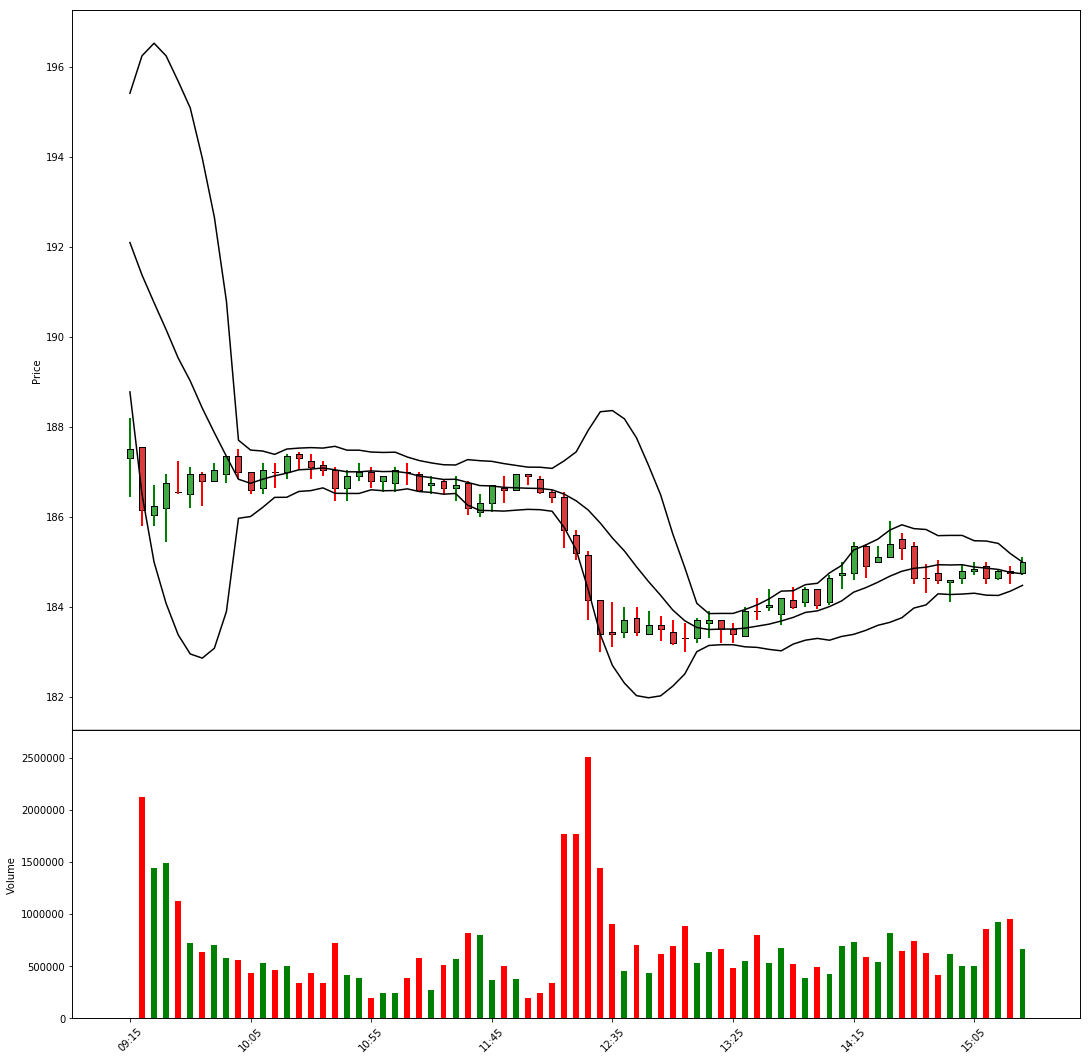

2020-04-15 13:45:00: BAJAJ-AUTO Long Signal
Entry Price: 2394.60009765625 at 2020-04-15 13:45:00
Target Price: 2412.559598388672
Stoploss Price: 2387.416297363281
Result:
Loss at 2020-04-15 13:55:00 at 2387.416297363281
Plotting Graph for confirmation...


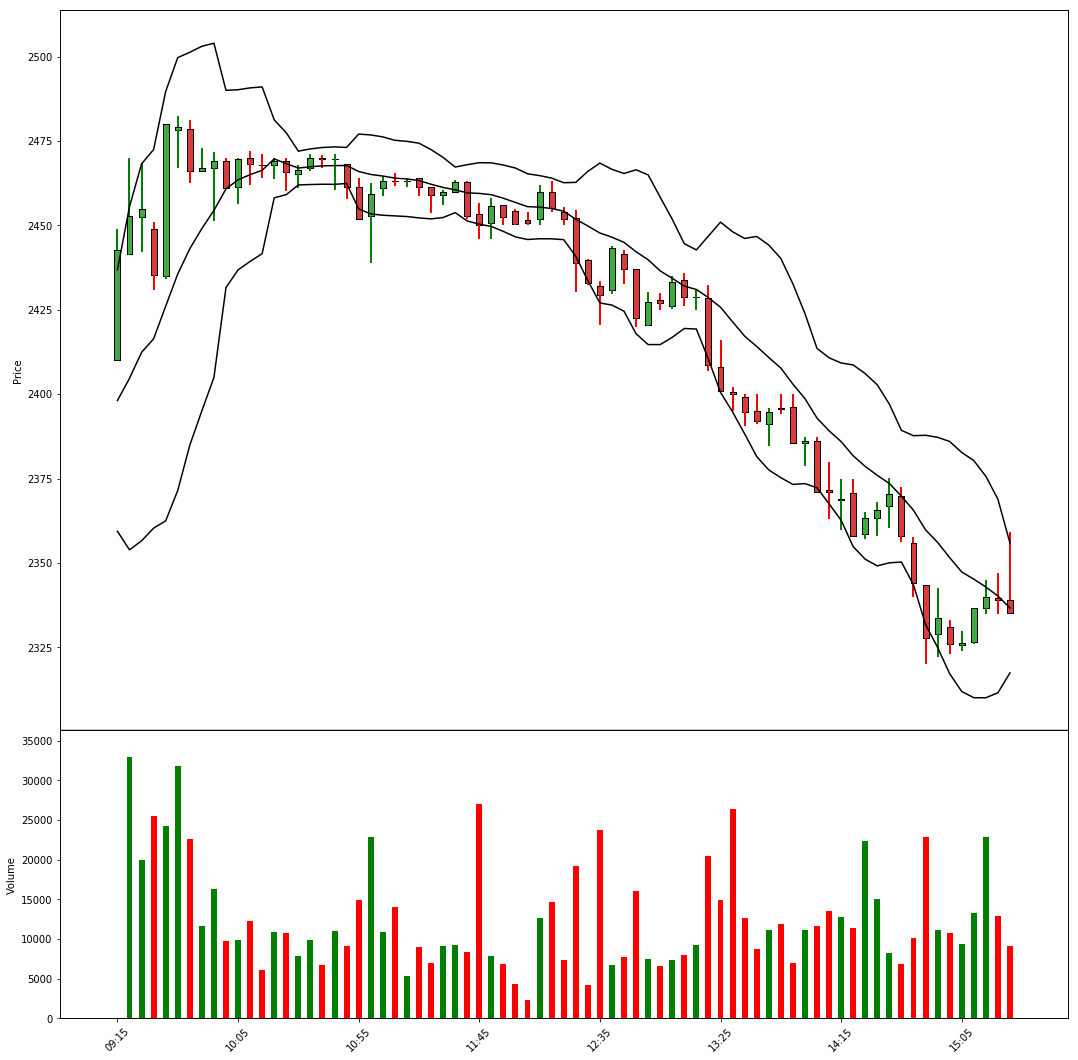

2020-04-21 12:40:00: ULTRACEMCO Long Signal
Entry Price: 3400.0 at 2020-04-21 12:40:00
Target Price: 3425.5
Stoploss Price: 3389.8
Result:
Loss at 2020-04-21 12:45:00 at 3389.8
Plotting Graph for confirmation...


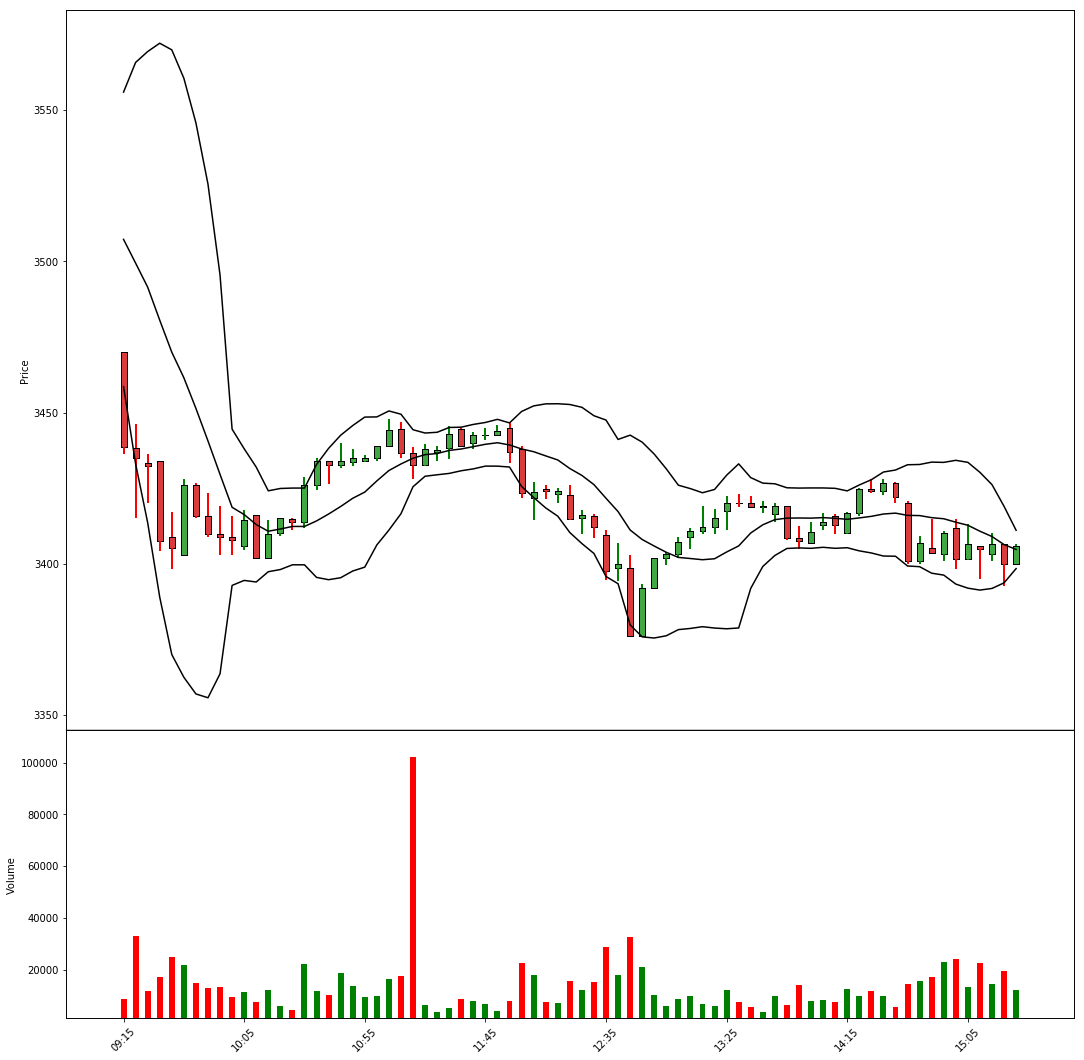

Overall Summary
Good Signals:8
Bad Signals:13
Mediocre Signals:0


In [7]:
good = 0
bad = 0
mediocre = 0

RSIrange = 25
RSIlimit = 29
simperiod = 11
takeprofit = .75
stoploss = .3

for name in company:
    data = pd.read_csv('C:/Users/user/Stockomation/Github/Data/NIFTY 50/5MIN/'+name+'.csv')
    for event in dates:
        good, bad, mediocre = simulate(data, event, name, RSIrange, RSIlimit, simperiod, takeprofit, stoploss, good, bad, mediocre)
        
print('Overall Summary')
print('Good Signals:' + str(good))
print('Bad Signals:' + str(bad))
print('Mediocre Signals:' + str(mediocre))